<a href="https://colab.research.google.com/github/Rhino-byte/Time-Series-/blob/main/Cryptocurrency_Analysis_In_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this Research we will be building GARCH models and Seasonal ARIMA models to help us analyse the patterns in the BITCOIN cryptocurrency

In [1]:
# Install neccesarry package
install.packages("zoo")
install.packages("xts")
install.packages("tidyverse")
install.packages("httr")
install.packages("jsonlite")
install.packages('quantmod')

library(xts)
library(zoo)
library(tidyverse)
library(httr)
library(jsonlite)
library(quantmod)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘TTR’


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────

The data we are going to use is based from [Kraken](https://pro.kraken.com/) which we shall extract using API.Before proceeding make sure you have created an account in Kraken to access the API's.

In [2]:
#@title API KEYs
#  private key
api_key<-'TS7dqZAFi9QPHa3FQSW/YGvCBG+gGMMzZrhcqysq1bjKe0WoaOs4sm2rgr37RHZ+eI/iyxuu570DYcztPHO6uA=='
# API_key
api_secret<-'99VP7jA7/qu1DEIOl+4FxvR+nTpZh9QfSgx8vXL8FPM7tRMatQSzjfRL'

In [3]:
load_api_keys <- function () {
api_key <- Sys.getenv (" KRAKEN_API_KEY ")
api_secret <- Sys.getenv (" KRAKEN_API_SECRET ")
return ( list ( key = api_key , secret = api_secret ) )
}

initialize_kraken_api <- function () {
keys <- load_api_keys ()
list (
key = api_key,
secret = api_secret)
}

**Food for thought:**To access any API the key requirements:

* API Key or Secret (optional depending on type of API)
* The parametres of the data you want to extract
* The URL for the API you want to access your data from

In [4]:
get_ohlc_data <- function(pair = "XXBTZUSD", interval = 1440) {
  # Initialize Kraken API
  api <- initialize_kraken_api()

  # Kraken API endpoint
  url <- "https://api.kraken.com/0/public/OHLC"

  # Parameters for the request
  params <- list(
    pair = pair,
    interval = interval # The time frame we want to use for our garch models
  )

  # Make the GET request
  response <- GET(url, query = params)
  # Check the status code
  if (status_code(response) != 200) {
    stop("Failed to fetch data from Kraken API. Status code: ", status_code(response))
  }

  # Parse the response
  content <- fromJSON(content(response, "text"), flatten = TRUE)

  # Extract OHLC data
  ohlc_data <- content$result[[pair]]

  if (is.null(ohlc_data)) {
    stop("No data found for the given pair.")
  }

  # Convert to data frame
  ohlc_df <- as.data.frame(ohlc_data)
  colnames(ohlc_df) <- c("time", "open", "high", "low", "close", "vwap", "volume", "count")

  # Convert time from UNIX timestamp to readable date
  ohlc_df$time <- as.POSIXct(as.integer(ohlc_df$time))

  return(ohlc_df)
}

Our Parameters for this API is (pair and interval) for more on kraken API [Documentation](https://docs.kraken.com/api/docs/rest-api/get-ohlc-data)

```
(pair)
string
required
Asset pair to get data for
Example: XBTUSD

(interval)
integer
Possible values: [1, 5, 15, 30, 60, 240, 1440, 10080, 21600]
Default value: 1
Time frame interval in minutes
Example: 60

(since)
integer
Return OHLC entries since the given timestamp (intended for incremental updates)
Maximum value of data you can retrieve is 720 observation from the recent observation

Example: 1688671200
```

In [5]:
BTC_data = get_ohlc_data(interval= 1440 )

No encoding supplied: defaulting to UTF-8.



In [6]:
# Convert all variables to numerical
BTC_data %>% mutate_if(is.character,as.numeric)->BTC_data

In [7]:
tail(BTC_data)

,time,open,high,low,close,vwap,volume,count
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
715,2024-10-15,66025.6,67871.1,64686.1,67060.5,66193.6,3990.0129,49705
716,2024-10-16,67056.0,68328.6,66751.5,67589.9,67655.5,1989.7485,33858
717,2024-10-17,67590.0,67899.9,66644.5,67407.8,67208.4,1581.8032,31915
718,2024-10-18,67407.8,68980.3,67189.9,68440.3,68262.2,1519.4474,32011
719,2024-10-19,68440.2,68632.7,68062.2,68374.9,68291.9,402.0001,15819
720,2024-10-20,68375.0,68393.2,68129.4,68168.1,68231.2,104.0903,3117


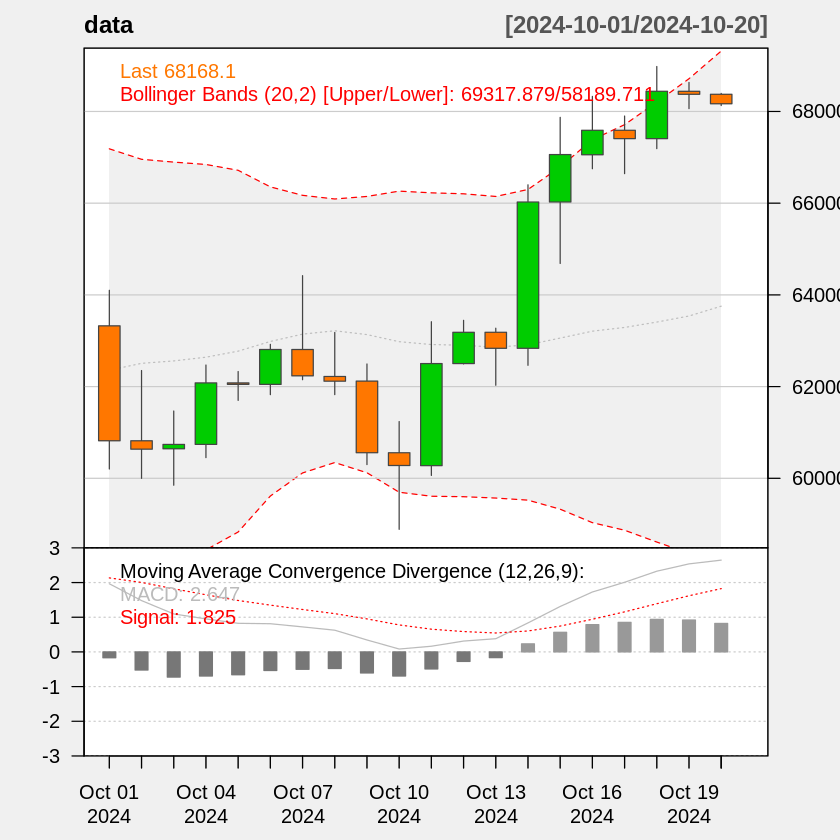

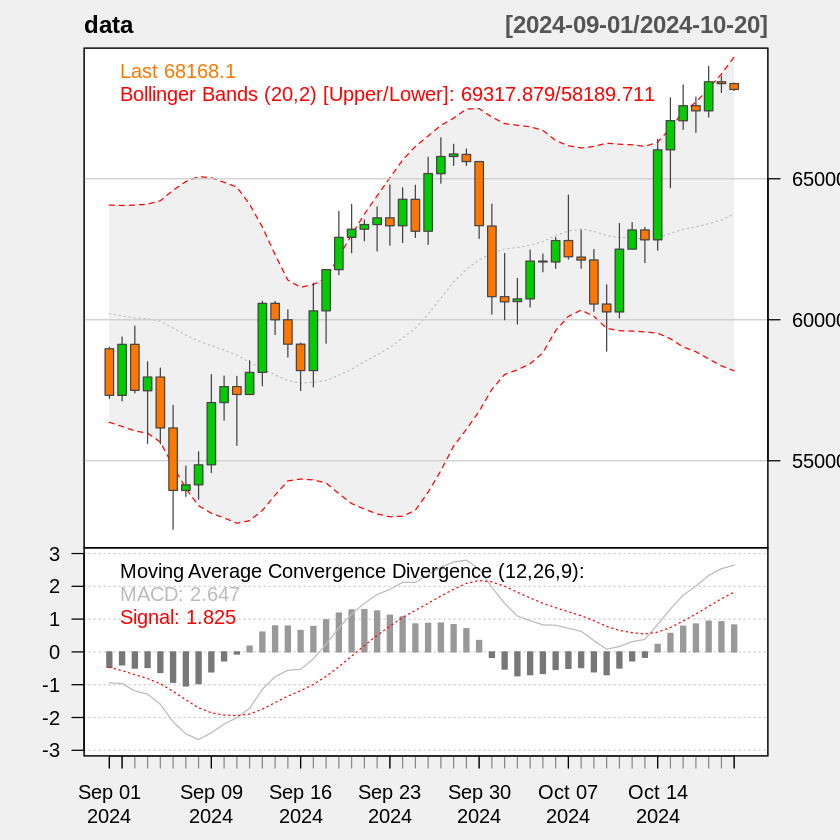

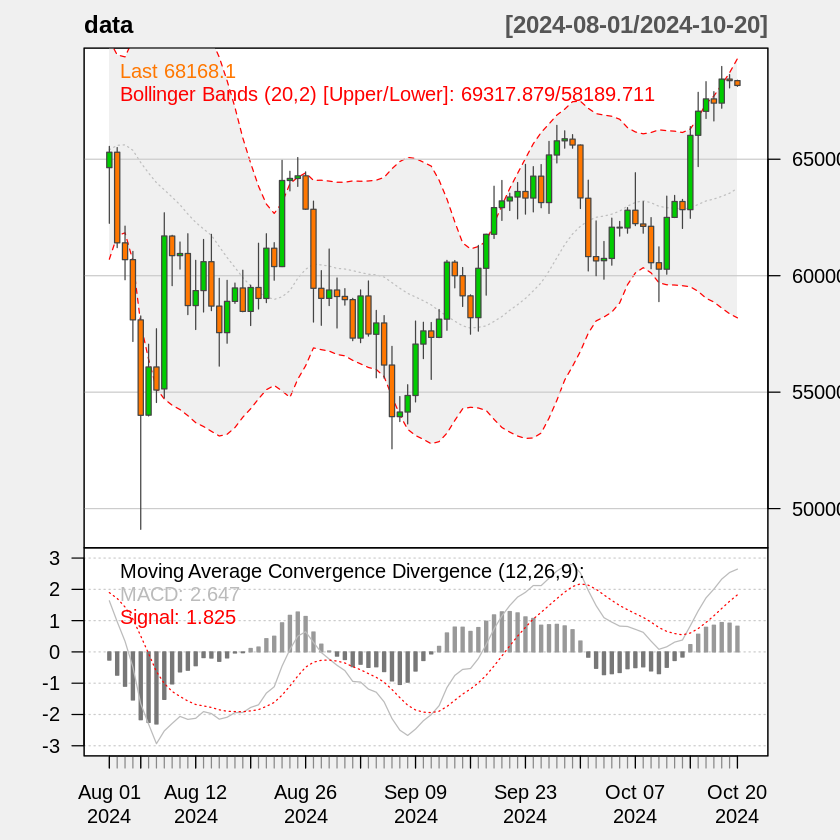

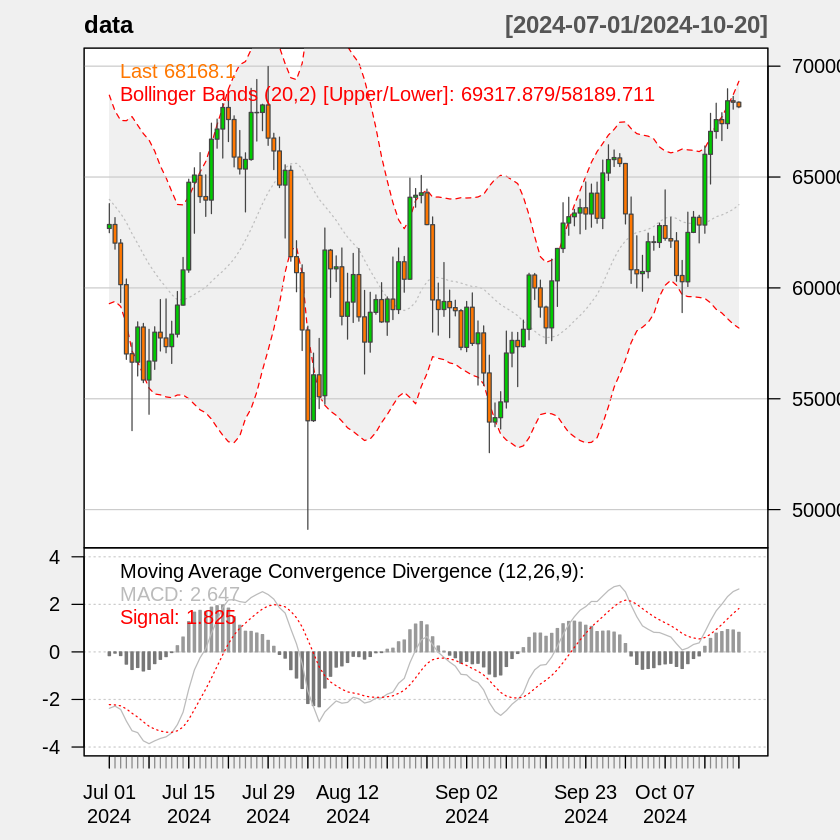

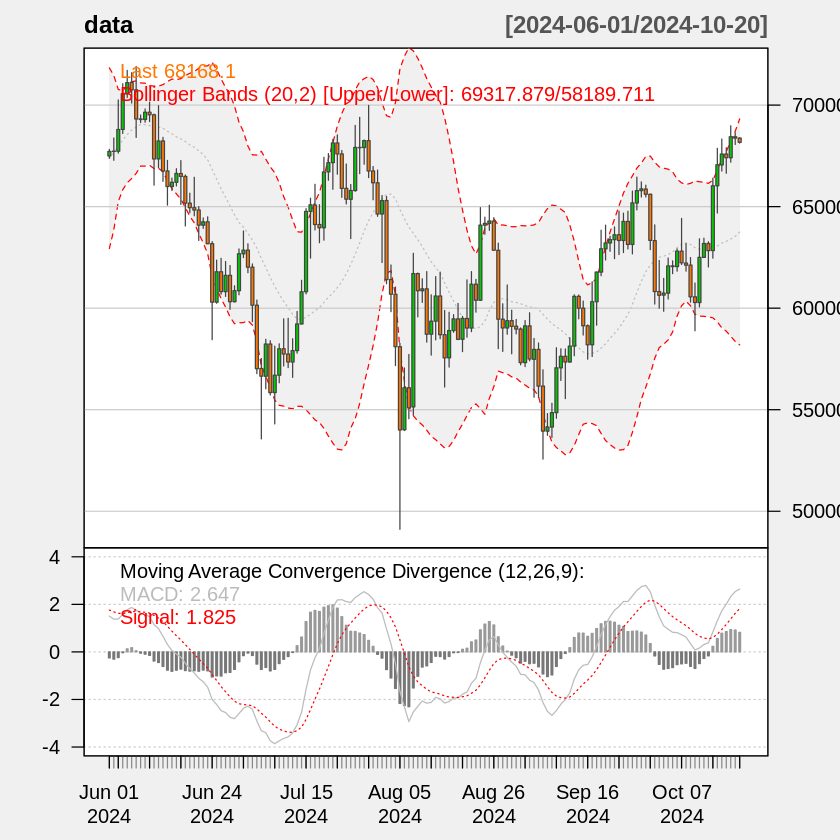

In [9]:
# plot the data
plot_series_chart<- function(data,n=4,time_interval = 'month'){
chartSeries(
  x = data,
  theme=chartTheme('white'),
  subset=paste('last',n,time_interval),
  TA = c(
    quantmod::addMACD(),
    quantmod::addBBands()
  ))
}

for(i in 1:5){
  plot_series_chart(BTC_data,n=i)
  }

By looping over our plot function with changing the size of the data while also looking at the trends formed in our time series data.It was fun🤯


In [10]:
names(BTC_data)

[1] "time"   "open"   "high"   "low"    "close"  "vwap"   "volume" "count"

What are **Asset returns:**🥸

The **price** of an asset as a function of time is perhaps the most natural financial time series, but it is not the best way to manipulate the data mathematically.

The price of any reasonable asset will increase exponentially with time, but most of our mathematical tools (e.g. correlation, regression) work most naturally with linear functions.

The mean value of an exponentially-increasing time series has no obvious meaning.
There are various types of returns but for this study we will use the [logarithimc(Compound)](https://saturncloud.io/blog/what-are-logarithmic-returns-and-how-to-calculate-them-in-pandas-dataframe/#:~:text=Logarithmic%20returns%20are%20also%20useful,over%20a%20period%20of%20time.) returns.

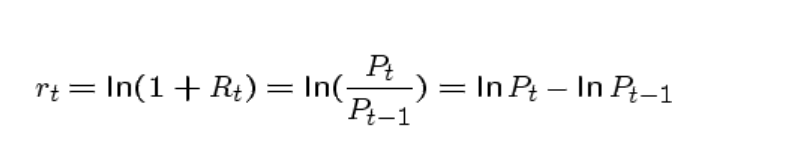

## Properties of Assets returns

If we consider the returns of a volatile asset, such the daily return on a stock, we would expect:

* The expected value will be small, probably near zero. Think about 10% return divided by 365 days.

* There should be a gross symmetry between negative returns and positive returns.

* Smaller absolute returns will occur more frequently than larger absolute returns

More notes on the [PerformanceAnalytics]('https://cran.r-project.org/web/packages/PerformanceAnalytics/PerformanceAnalytics.pdf') package

In [11]:
# Install package for calculating returns(also good for financial time series)
install.packages("PerformanceAnalytics")
install.packages("forecast")
# install.packages('cowplot')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘quadprog’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘RcppArmadillo’




To calculate the returns we use the closing prices of the stock index

In [34]:
library(zoo)
ts_data = read.zoo(BTC_data %>% dplyr::select(time,close) )
head(ts_data)


2022-11-01 2022-11-02 2022-11-03 2022-11-04 2022-11-05 2022-11-06 
   20486.5    20153.5    20209.1    21148.7    21299.5    20910.8 

In [41]:
# Extract the returns
library(PerformanceAnalytics)
returns =  CalculateReturns(as.ts(BTC_data$close),'compound')#[-1]
# head(returns)

#Add a time variable to our returns
df =data.frame(time<-BTC_data$time,returns)
returns = read.zoo(df) # using the zoo file

# We need to remove the missing value this is brought about differencing the data
returns =returns[-1]


## ACF and PACF plots 🧐

[Autocorrelation](https://www.influxdata.com/blog/autocorrelation-in-time-series-data/)
 refers to the degree of similarity between A) a given time series, and B) a lagged version of itself, over C) successive time intervals. In other words, autocorrelation is intended to measure the relationship between a variable’s present value and any past values that you may have access to.


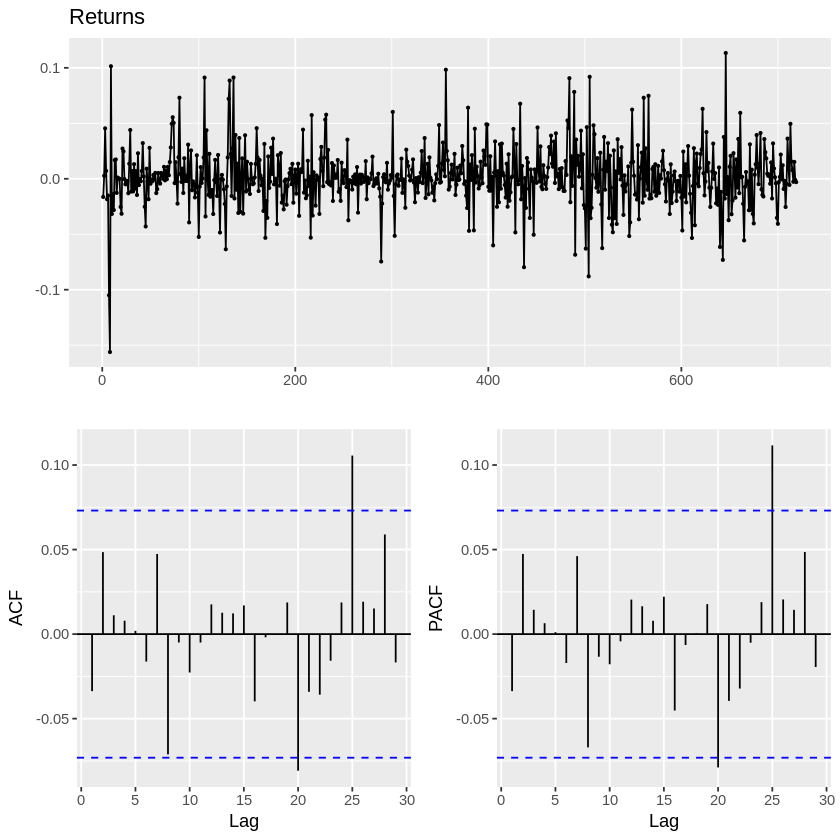

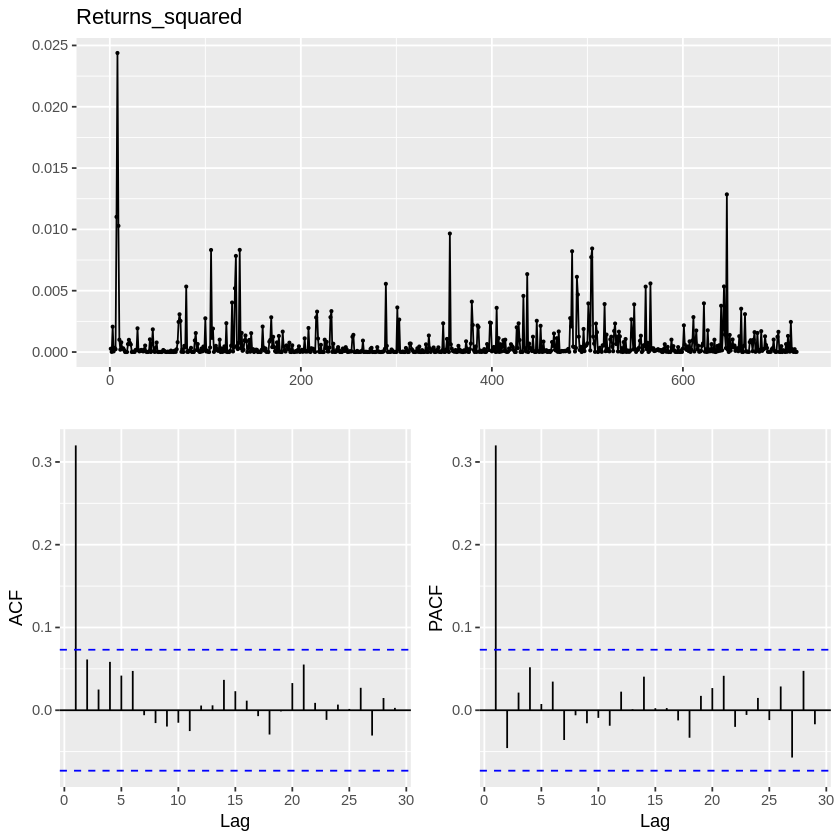

In [44]:
library(forecast)

# Plot the returns and the returns_squared
ggtsdisplay(returns,main ='Returns')
ggtsdisplay(returns^2,main='Returns_squared')



Based on the daily returns we observe volatility in the `BTCUSD` pair market

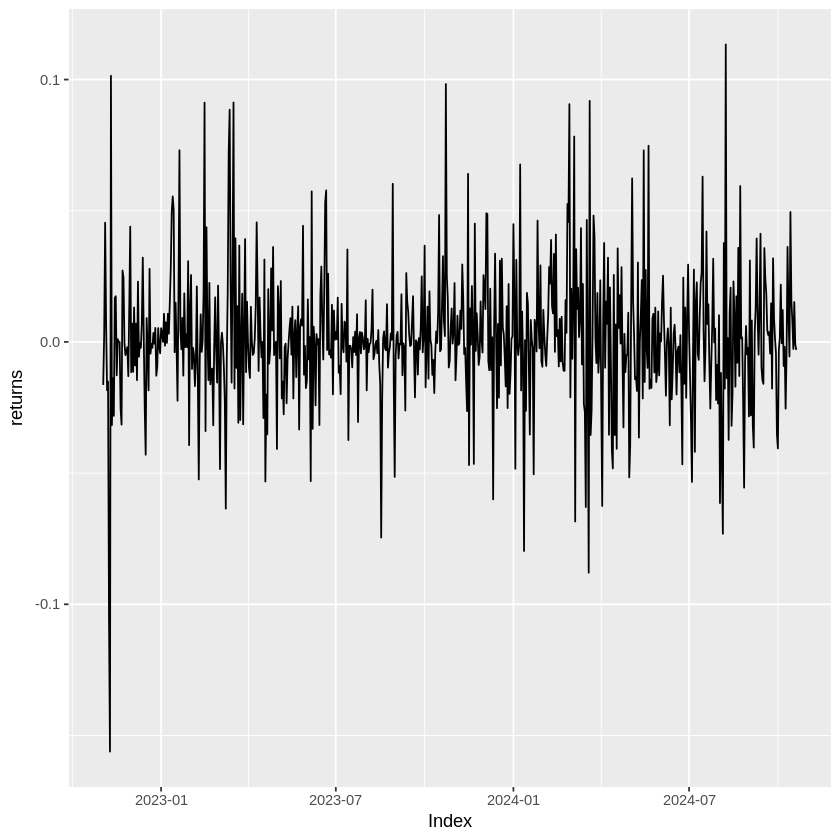

In [45]:
# Investigating volatility
autoplot(returns)
# High volatility present in the time series data

In [46]:
# let's compute the annualized standard devi
sd(returns)
# let's compute

[1] 0.02589233

## Rolling volatility

* You can visualize the time-variation in volatility by using the function `chart.RollingPerformance()` in the package `PerformanceAnalytics`.

*  An important tuning parameter is the choice of the `window length`. The shorter the window, the more responsive the rolling volatility estimate is to recent returns. The longer the window, the smoother it will be.

* The function `sd.annualized` lets you compute annualized volatility under the assumption that the number of trading days in a year equals the number specified in the scale argument.

**Note:**🔑💡In a month the trading days = 22 whereas in a year =252

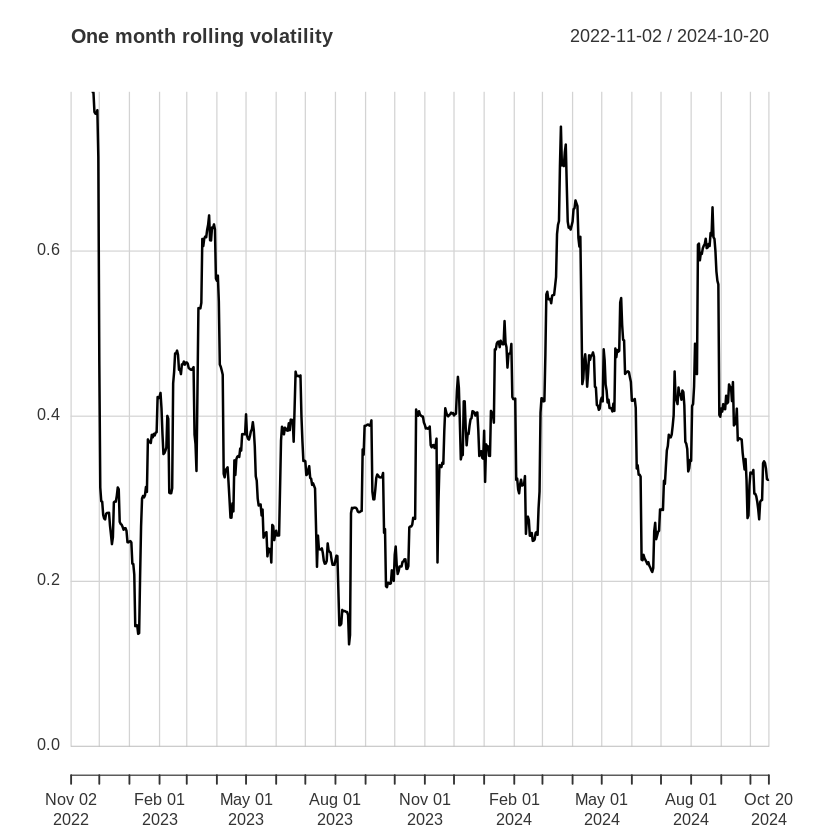

In [47]:
# Compute the rolling 1 month estimate of annualized volatility
chart.RollingPerformance(R = returns,width = 22,
FUN ="sd.annualized",scale =252,main="One month rolling volatility")


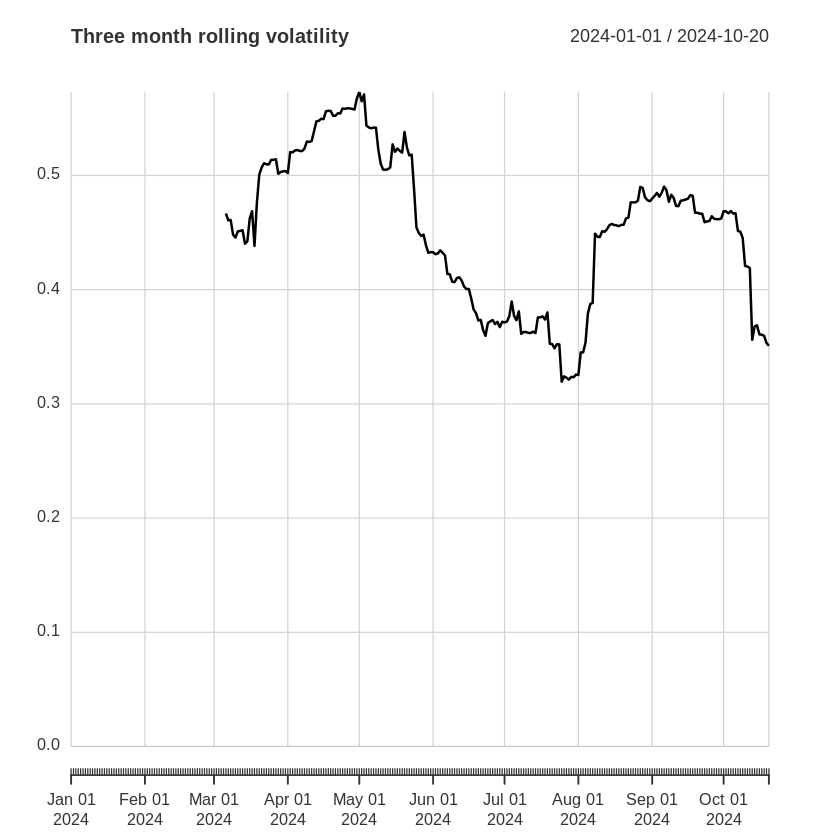

In [56]:
# Compute three month volatility for the year 2024

# Assuming 'returns' is your zoo object with a date index
start_date <- as.Date("2024-01-01")
end_date <- as.Date("2024-10-20")

# Extract data within the specified date range
returns_subset <- window(returns, start = start_date, end = end_date)

# plot the data
chart.RollingPerformance(R=returns_subset,width = 66, # Remember 22 *3
FUN ="sd.annualized",scale =252,main="Three month rolling volatility"
)

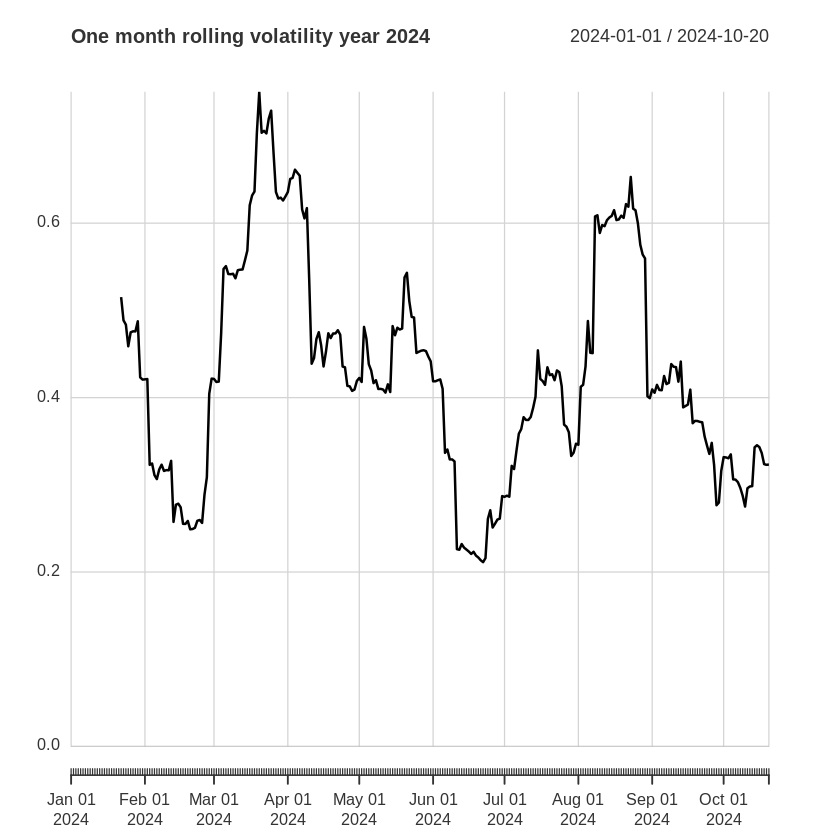

In [57]:
# plot the data
chart.RollingPerformance(R=returns_subset,width = 22, # Remember 22 *3
FUN ="sd.annualized",scale =252,main="One month rolling volatility year 2024"
)

## GARCH Models
I Prepared some slides to enlighten more on [garch models](https://github.com/Rhino-byte/Time-Series-/blob/main/chapter1.pdf) or watch [datacamp](https://campus.datacamp.com/courses/garch-models-in-r/the-standard-garch-model-as-the-workhorse-model?ex=5) video.

For this section we will begin by understanding the Garch equation for volatility predictions


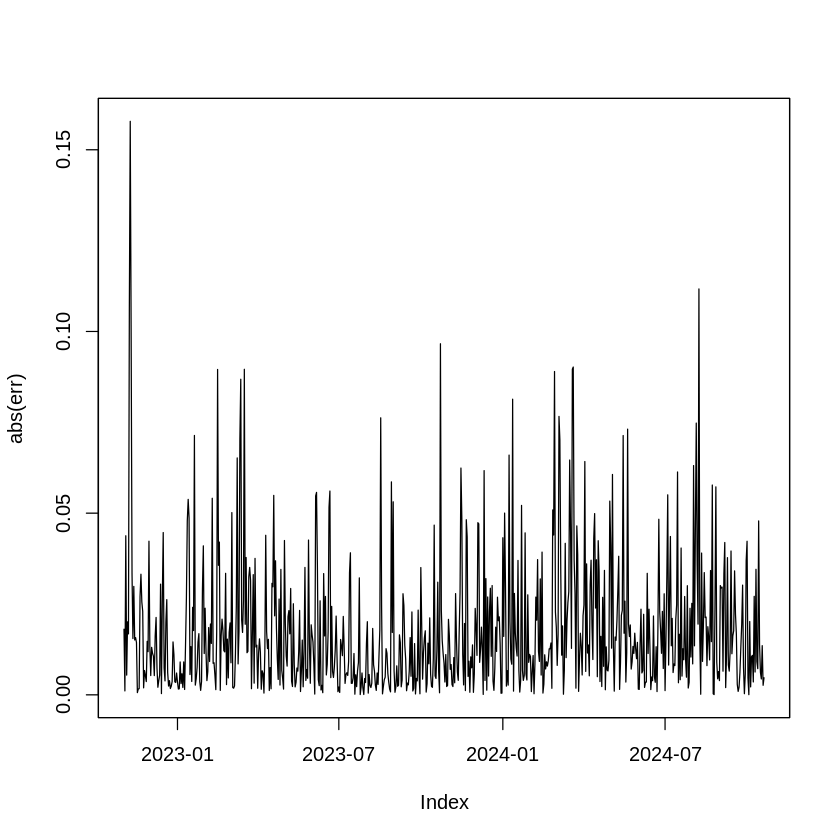

In [61]:
# Compute the mean daily returns
sample_mean =mean(returns)

# Define the series of prediction
err <- returns - sample_mean

# Plot the absolute value of the prediction errors
plot(abs(err))



Note the waves in the absolute prediction errors in the top plot. They correspond to the presence of high and low volatility clusters. In the bottom plot, you can see the large positive autocorrelations in the absolute prediction errors. Most of them are above 0.08.

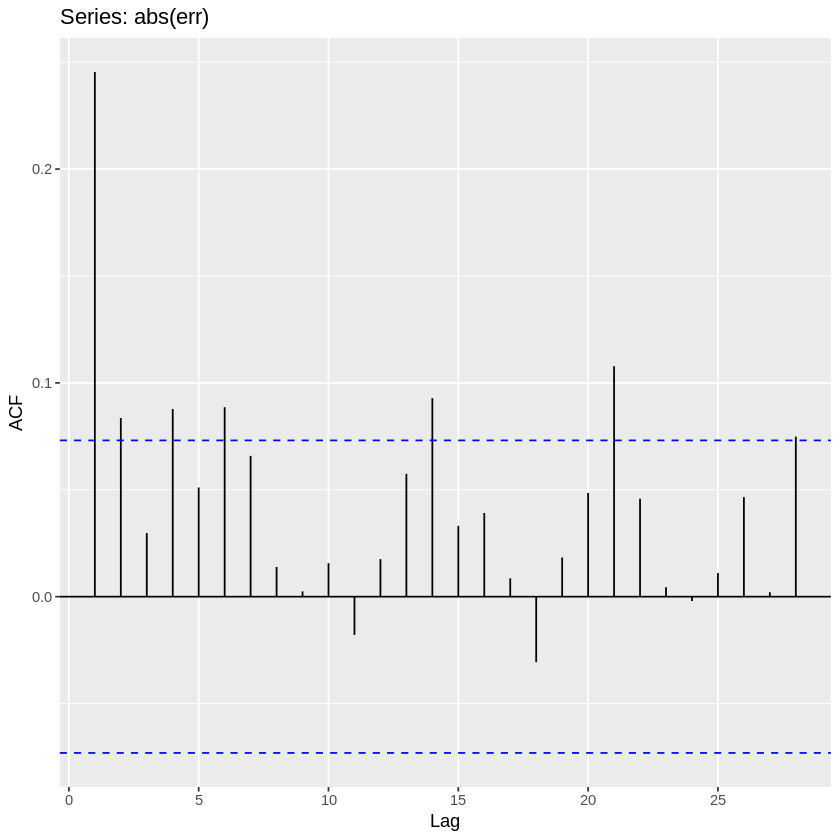

In [63]:
# Plot the acf of the absolute prediction errors
ggAcf(abs(err))

We need to fit a GARCH model and extract
`alpha`,`omega`,`beta` and the `mean` to be able to calclate the predicted variance

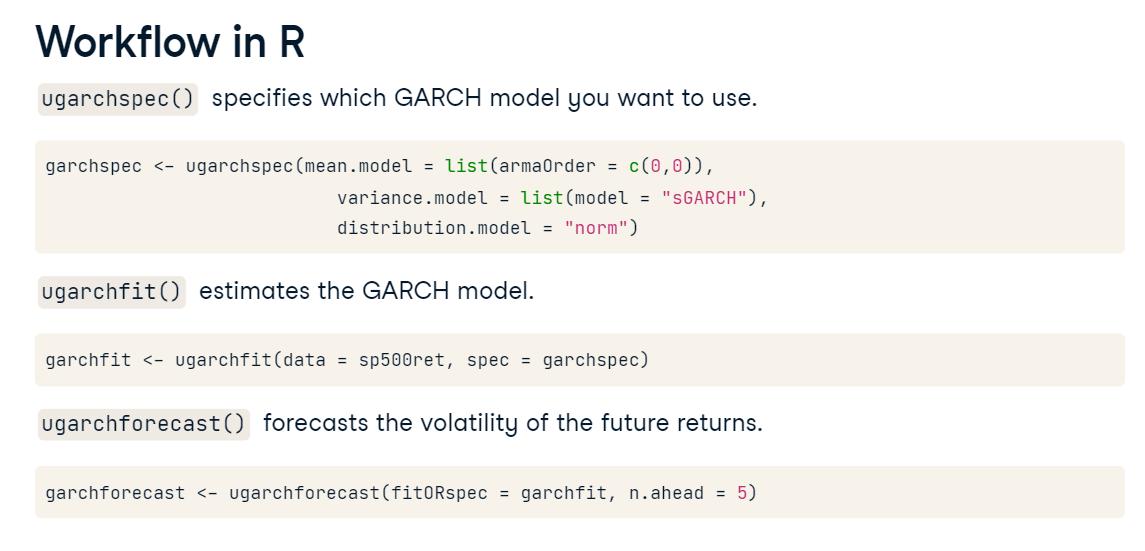

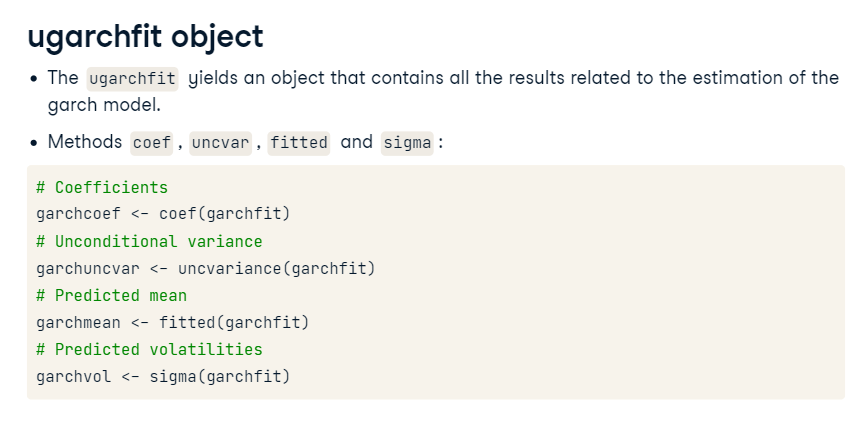

In [ ]:
safe_model_fit <- function(fit_function, model_name) {
    tryCatch({
      model <- fit_function()
      forecast <- forecast::forecast(model, h = length(test_data))$mean
      ic <- AIC(model)
      model_smape <- smape(test_data, forecast)
      list(Order = list(arimaorder(model)), Error = FALSE, IC = ic, SMAPE = model_smape)
    }, error = function(e) {
      # If the model fails, return NA and mark as error
      list(Order = list(NA), Error = TRUE, IC = NA, SMAPE = NA)
    })
  }